In [19]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
from sklearn.decomposition import NMF, IncrementalPCA
from scipy.stats import ortho_group
from scipy.linalg import eigh
import fbpca
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import logging
import unittest
import math
import numpy as np
from scipy.linalg import cholesky, eigh, lu, qr, svd, norm, solve
from scipy.sparse import coo_matrix, issparse, spdiags


os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [20]:
def diffsnorm(A, U, s, Va, n_iter=20):
	"""
	2-norm accuracy of an approx to a matrix.
	Computes an estimate snorm of the spectral norm (the operator norm
	induced by the Euclidean vector norm) of A - U diag(s) Va, using
	n_iter iterations of the power method started with a random vector;
	n_iter must be a positive integer.
	Increasing n_iter improves the accuracy of the estimate snorm of
	the spectral norm of A - U diag(s) Va.
	Notes
	-----
	To obtain repeatable results, reset the seed for the pseudorandom
	number generator.
	Parameters
	----------
	A : array_like
		first matrix in A - U diag(s) Va whose spectral norm is being
		estimated
	U : array_like
		second matrix in A - U diag(s) Va whose spectral norm is being
		estimated
	s : array_like
		vector in A - U diag(s) Va whose spectral norm is being
		estimated
	Va : array_like
		fourth matrix in A - U diag(s) Va whose spectral norm is being
		estimated
	n_iter : int, optional
		number of iterations of the power method to conduct;
		n_iter must be a positive integer, and defaults to 20
	Returns
	-------
	float
		an estimate of the spectral norm of A - U diag(s) Va (the
		estimate fails to be accurate with exponentially low prob. as
		n_iter increases; see references DM1_, DM2_, and DM3_ below)
	Examples
	--------
	>>> from fbpca import diffsnorm, pca
	>>> from numpy.random import uniform
	>>> from scipy.linalg import svd
	>>>
	>>> A = uniform(low=-1.0, high=1.0, size=(100, 2))
	>>> A = A.dot(uniform(low=-1.0, high=1.0, size=(2, 100)))
	>>> (U, s, Va) = svd(A, full_matrices=False)
	>>> A = A / s[0]
	>>>
	>>> (U, s, Va) = pca(A, 2, True)
	>>> err = diffsnorm(A, U, s, Va)
	>>> print(err)
	This example produces a rank-2 approximation U diag(s) Va to A such
	that the columns of U are orthonormal, as are the rows of Va, and
	the entries of s are all nonnegative and are nonincreasing.
	diffsnorm(A, U, s, Va) outputs an estimate of the spectral norm of
	A - U diag(s) Va, which should be close to the machine precision.
	References
	----------
	.. [DM1] Jacek Kuczynski and Henryk Wozniakowski, Estimating the
			 largest eigenvalues by the power and Lanczos methods with
			 a random start, SIAM Journal on Matrix Analysis and
			 Applications, 13 (4): 1094-1122, 1992.
	.. [DM2] Edo Liberty, Franco Woolfe, Per-Gunnar Martinsson,
			 Vladimir Rokhlin, and Mark Tygert, Randomized algorithms
			 for the low-rank approximation of matrices, Proceedings of
			 the National Academy of Sciences (USA), 104 (51):
			 20167-20172, 2007. (See the appendix.)
	.. [DM3] Franco Woolfe, Edo Liberty, Vladimir Rokhlin, and Mark
			 Tygert, A fast randomized algorithm for the approximation
			 of matrices, Applied and Computational Harmonic Analysis,
			 25 (3): 335-366, 2008. (See Section 3.4.)
	See also
	--------
	diffsnormc, pca
	"""

	(m, n) = A.shape
	(m2, k) = U.shape
	k2 = len(s)
	l = len(s)
	(l2, n2) = Va.shape

	assert m == m2
	assert k == k2
	assert l == l2
	assert n == n2

	assert n_iter >= 1

	if np.isrealobj(A) and np.isrealobj(U) and np.isrealobj(s) and \
			np.isrealobj(Va):
		isreal = True
	else:
		isreal = False

	# Promote the types of integer data to float data.
	dtype = (A * 1.0).dtype

	if m >= n:

		if isreal:
			x = np.random.normal(size=(n, 1)).astype(dtype)
		else:
			x = np.random.normal(size=(n, 1)).astype(dtype) \
				+ 1j * np.random.normal(size=(n, 1)).astype(dtype)

		x = x / norm(x)

		for it in range(n_iter):

			y = mult(A, x) - U.dot(np.diag(s).dot(Va.dot(x)))
			x = mult(y.conj().T, A).conj().T \
				- Va.conj().T.dot(np.diag(s).conj().T.dot(U.conj().T.dot(y)))

			snorm = norm(x)
			if snorm == 0:
				return 0

			x = x / snorm

		snorm = math.sqrt(snorm)

	if m < n:

		if isreal:
			y = np.random.normal(size=(m, 1)).astype(dtype)
		else:
			y = np.random.normal(size=(m, 1)).astype(dtype) \
				+ 1j * np.random.normal(size=(m, 1)).astype(dtype)

		y = y / norm(y)

		for it in range(n_iter):

			x = mult(y.conj().T, A).conj().T \
				- Va.conj().T.dot(np.diag(s).conj().T.dot(U.conj().T.dot(y)))

			y = mult(A, x) - U.dot(np.diag(s).dot(Va.dot(x)))

			snorm = norm(y)

			if snorm == 0:
				return 0

			y = y / snorm

		snorm = math.sqrt(snorm)

	return snorm


In [38]:
path = '/home/jae/Downloads/data32.raw'

In [39]:
dataset = np.memmap(path, dtype=np.float32, mode="w+", shape=(32, 32, 32, 32))

In [40]:
start = time.time()
for i in range(32):
    for j in range(32):
        loading = np.random.normal(loc=0, scale=1, size=(32, 32))
        components = ortho_group.rvs(dim=32)
        dataset[i, j, :, :] = loading @ components
# loading = np.random.normal(loc=0, scale=1, size=(256, 256)) # create loading matrix
end = time.time()
print(end-start)

2.0615005493164062


In [146]:
1094/60

18.233333333333334

In [41]:
del dataset

In [42]:
call_data = np.memmap(path, dtype=np.float32, mode="r+", shape=(32, 32, 32,32))

In [24]:
call_data.shape

(64, 64, 64, 64)

In [ ]:
path = '/home/jae/Downloads/saved_data.raw'
data = np.random.rand(256, 256, 128, 128)
# data.tofile(path)
# data = _mk_random(size=(256, 256, 128, 128), dtype="float32")
dataset = np.memmap(path, dtype=np.float32, mode="w+", shape=(256, 256, 128, 128))

In [47]:
data = data.reshape((16, 16, 16, 16))

ValueError: cannot reshape array of size 4096 into shape (16,16)

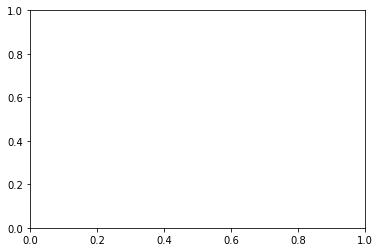

In [24]:
fig, axes = plt.subplots()
axes.imshow(data[:, 0].reshape(16, 16))

In [9]:
class IPCA:

    def __init__(self, K, D, Uhat0=None, sigma2_0=None, tol=1e-7):

        if Uhat0 is not None:
            assert Uhat0.shape == (D, K), "The shape of the initial guess Uhat0 must be (D,K)=(%d,%d)" % (D, K)
            self.Uhat = Uhat0.copy()

        else:
            # random initalization if not provided
            self.Uhat = np.random.normal(loc=0, scale=1 / D, size=(D, K))

        self.t = 1

        if sigma2_0 is not None:
            assert sigma2_0.shape == (K,), "The shape of the initial guess lambda0 must be (K,)=(%d,)" % (K)
            self.sigma2 = sigma2_0.copy()
        else:
            self.sigma2 = np.abs(np.random.normal(0, 1, (K,))) / np.sqrt(K)

        self.K = K
        self.D = D
        self.f = 1.0 / self.t
        self.tol = tol

    def fit_next(self, x):

        assert x.shape == (self.D,)
        self.t += 1
        self.f = 1.0 / self.t

        t, f, sigma2, Uhat, K, tol = self.t, self.f, self.sigma2, self.Uhat, self.K, self.tol

        sigma2 = (1 - f) * sigma2
        x = np.sqrt(f) * x

        # Project X into current estimate and check residual error
        y     = Uhat.T.dot(x)
        x     = x - Uhat.dot(y)
        normx = np.sqrt(x.dot(x))

        if (normx >= tol):
            sigma2 = np.concatenate((sigma2, [0]))
            y = np.concatenate((y, [normx]))
            Uhat = np.concatenate((Uhat, x[:, np.newaxis] / normx), 1)

        M = np.diag(sigma2) + np.outer(y, y.T)
        d, V = eigh(M, overwrite_a=True)

        idx    = np.argsort(d)[::-1]
        sigma2 = d[idx][:K]
        V      = V[:, idx]
        Uhat   = Uhat.dot(V[:, :K])

        self.Uhat   = Uhat
        self.sigma2 = sigma2

    def get_components(self, orthogonalize=True):

        components = np.asarray(self.Uhat)
        if orthogonalize:
            components, _ = np.linalg.qr(components)

        return components


In [10]:
def process_frame(ipca, frame):
    """
    Process frame as it is done in libertem architecture
    """
    frame_flatten = frame.reshape(frame.size,)
    ipca.fit_next(frame_flatten)

In [11]:
def process_partitions(prev, partitions):
    """
    Process partitions as it is done in libertem architecture
    i.e., stack up partitions, which are components vectors
    """
    return np.vstack([prev, partitions])

In [26]:
def perform_pca(component, n_components=10):
    """
    Perform PCA
    """
    U, S, V = fbpca.pca(component, k=n_components)
    
#     loading = U @ S
#     component = V
    
    return U, S, V
    

SyntaxError: invalid syntax (<ipython-input-13-3276a8ab1e52>, line 1)

In [14]:
def partition(data, num_part=16):
    """
    Partition the data as it is done in libertem architecture
    """
    nav_row, nav_col, sig_row, sig_col = data.shape
    
    partitions = []
    
    for i in range(0, nav_row, num_part):
        for j in range(0, nav_col, num_part):
            partitions.append(data[i:i+num_part, j:j+num_part, :, :].copy())

    return partitions

In [15]:
def fetch_frame(partition):
    """
    Take a frame from a partition as it is done in libertem architecture
    """
    frames = []
    
    part_row, part_col, sig_row, sig_col = partition.shape
    
    for i in range(part_row):
        for j in range(part_col):
            frames.append(partition[i, j, :, :].copy())
            
    return frames

In [16]:
def flatten(frames):
    """
    Given a list of frames, flatten them and stack them up
    """
    flattened = None
    i = 0
    for frame in frames:
        frame_flatten = frame.reshape(1, frame.size)
        if i != 0:
            flattened = np.vstack([flattened, frame_flatten])
        else:
            flattened = frame_flatten
        i += 1
    return flattened
        

In [27]:
def PCA(data):
    """
    Perform PCA as it is done in liberteme architecture under UDF interface
    """
    sig_dim = data.shape[2] * data.shape[3]
    partitions = partition(data)
    i = False
    
    start = time.time()
    for part in partitions:
        frames = fetch_frame(part)
        
#         ipca = IPCA(K=16, D=sig_dim)
        # flatten frames
        flattened_frames = flatten(frames)
        ipca = IncrementalPCA(n_components=10, batch_size=10).fit(flattened_frames)
#         for frame in frames:
#             process_frame(ipca, frame)

        part_comp = ipca.components_
        
#         print(part_comp.shape)
        if not i:
            components = part_comp
        else:
            components = process_partitions(components, part_comp)
            
        i = True
        part = time.time()
        
        
    
#     print(components.shape)
    U,S,V = perform_pca(components, n_components=16)
    pca_run = time.time()
    
    return U,S,V
        
        
            

In [43]:
start = time.time()
U,S,V = PCA(call_data)
end = time.time()

print(end-start)

/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


0.5022697448730469


/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/sklearn/decomposition/incremental_pca.py:294: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/home/jae/anaconda3/envs/libertem/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [44]:
U.shape

(40, 16)

In [45]:
data = call_data.reshape((call_data.shape[0]*call_data.shape[1], call_data.shape[2]*call_data.shape[3]))

In [36]:
component = component[:5, :]

memmap([[ 1.7168850e-01, -2.6253068e+00,  6.1638170e-01, ...,
          1.0108844e+00, -5.6665093e-01,  7.0936984e-01],
        [ 1.1181272e+00,  8.5225981e-01, -1.0177771e+00, ...,
         -1.1301740e+00, -2.0711696e+00,  1.3959797e-01],
        [ 1.4009737e+00, -9.9029535e-01,  9.1390610e-01, ...,
          6.4021373e-01, -1.6858639e-01, -2.7667844e-01],
        ...,
        [-1.8374518e+00,  3.3471707e-01, -1.6073637e+00, ...,
          2.6555443e+00, -5.2581829e-01,  2.1306276e+00],
        [-1.4336877e+00,  1.4701743e+00, -1.5168190e-03, ...,
          8.2295114e-01,  2.9995480e-01, -9.2373329e-01],
        [-1.4503164e+00,  4.7321633e-01,  6.3569260e-01, ...,
         -2.0031871e-02, -4.8230496e-01,  1.6543891e+00]], dtype=float32)

In [46]:
start = time.time()
component = V
projected_data = data @ component.T
end = time.time()
print(end-start)

0.016306161880493164


In [52]:
projected_data[:1]

array([[ 0.34290011,  1.50997335, -0.65434087, -0.59391729, -1.1754004 ,
        -0.23637501, -0.06971391, -0.18136068, -0.0151425 , -0.6210224 ,
         0.43507428, -0.25785328,  3.4060158 ,  3.21446729, -0.61316516,
        -2.55470907]])

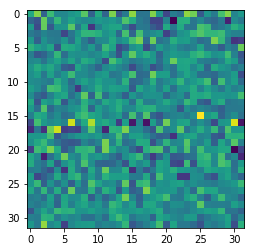

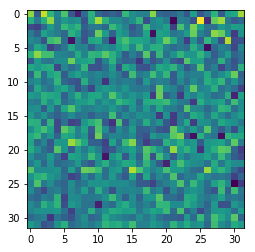

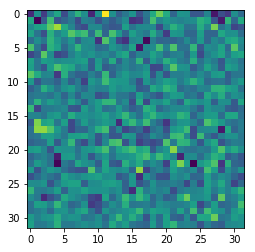

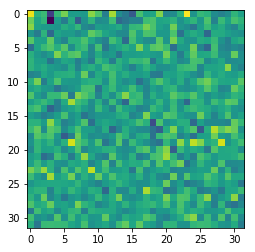

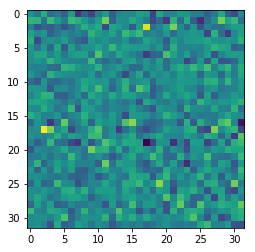

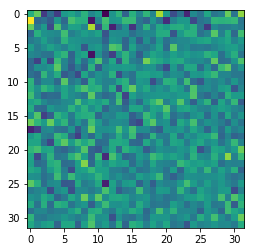

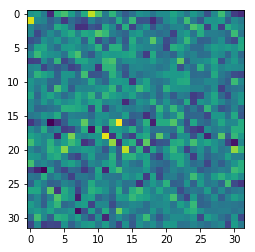

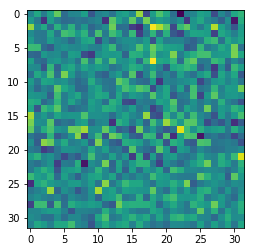

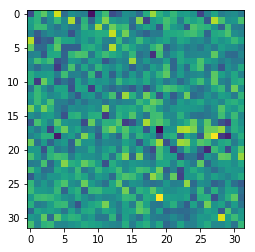

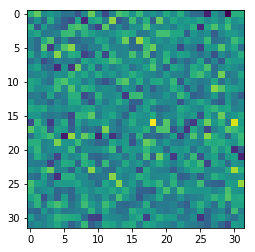

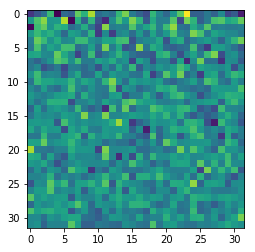

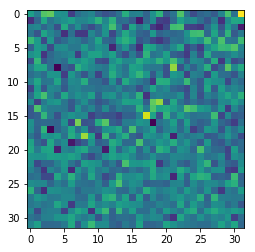

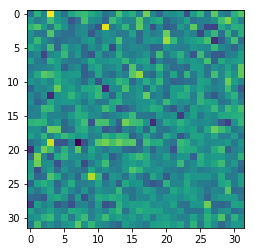

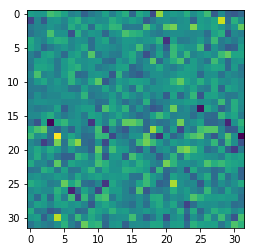

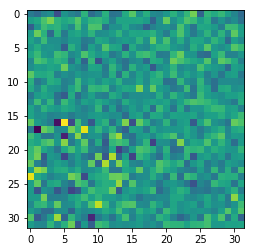

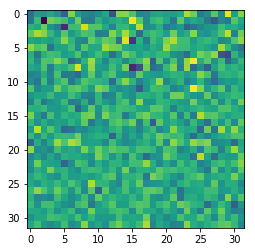

In [47]:
for i in range(16):
    fig, axes = plt.subplots()
    axes.imshow(projected_data[:, i].reshape(32, 32))
    
#     fig1, axes1 = plt.subplots()
#     axes1.imshow(call_data[:, 0].reshape(64, 64))

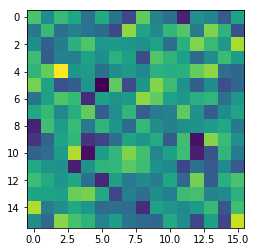

In [30]:
fig, axes = plt.subplots()
axes.imshow(data[:, 0].reshape(16, 16))